Assignment:
1. you have to create one supervisor node.
2. create one router function
3. create three more node
3.1 llm call (llm node)
3.2 RAG (rag node)
3.3 web crawler(fetch the info in realtime from internet)
4. created one more node after this for validation for generated output --> explore the validation part how to do that
5. if validation going to be failed in that case again go to supervioser node and then supervisor node will again decide what needs to be call next
6. once the validation will pass then only generate the final output

### Load ENV and WebSearch Tool

In [192]:
import os
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
load_dotenv()
WS_TOOL=TavilySearchResults(api_key=os.getenv("TAVILY_API_KEY"), max_results=3)

### LLM and Embedding Model:

In [193]:
# Get LLM
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_huggingface import HuggingFaceEmbeddings
MODEL=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
EMBEDDING=HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(EMBEDDING.embed_query("Hi"))

384

### Load & Split Document and Create Vector DB

In [194]:
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_community.vectorstores import Chroma, FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

loader=DirectoryLoader(path='Data',glob="./*.txt",loader_cls=TextLoader)

docs=loader.load()

text_splitter=RecursiveCharacterTextSplitter(
    chunk_size=200,
    chunk_overlap=50
)

split_docs=text_splitter.split_documents(documents=docs)
print("Number of Documents:", len(split_docs))

db=FAISS.from_documents(split_docs,EMBEDDING)
retriever = db.as_retriever(search_kwargs={'k': 4})

Number of Documents: 55


### Pydantic Class and Parser:

In [195]:
from pydantic import BaseModel, Field
from langchain.output_parsers import PydanticOutputParser

class TopicSelctionParser(BaseModel): #Pydantic class for Supervisor
    Topic:str=Field(description="Selected Topic")
    Reasoning:str=Field(description="Reasoning behind topic selection")
topic_selction_parser=PydanticOutputParser(pydantic_object=TopicSelctionParser)

class ValidateOutputParser(BaseModel): #Pydantic class for RAG
    Validation:str=Field(description="Answer is Valid or Invalid")
    Reasoning:str=Field(description="Validation reason")
validate_output_parser=PydanticOutputParser(pydantic_object=ValidateOutputParser)

### Prompt Templates:

In [196]:
# Prompt Template for Supervisor Node:
supervisor_template="""
    Your task is to classify the given user query into one of the following categories: [USA, Not Related]. 
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """

# RAG Prompt Template:
rag_template="""
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
    If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
    
    \nQuestion: {question} 
    \nContext: {context} 
    \nAnswer:
    """

# Answer Validation Template:
validation_template="""
    Your task is to classify the given user question and answer into one of the following categories: [Valid, Invalid]. 
    Answer is valid if it directly answers the question without asking to refer external website for exact answer.
    Only respond with the category name and nothing else.

    Question: {question}
    Answer: {answer}
    {format_instructions}
    """

# Web Context prompt Template
web_template="""
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question.
    Use three sentences maximum to answer the question in concise, add source information if available.
    
    \nQuestion: {question} 
    \nContext: {context} 
    \nAnswer:
    """

### Define AgentState:

In [197]:
import operator
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

### Supervisor Node:

In [198]:
from langchain_core.prompts import PromptTemplate
def supervisor_fun(state:AgentState):
    
    question=state["messages"][-1]
    
    print("***** Supervisor Node *****")
    print("Question: ",question)
   
    prompt= PromptTemplate(
        template=supervisor_template,
        input_variable=["question"],
        partial_variables={"format_instructions": topic_selction_parser.get_format_instructions()}
    )
    
    chain= prompt | MODEL | topic_selction_parser
    
    response = chain.invoke({"question":question})
    
    print("Response:", response)
    
    return {"messages": [response.Topic]}

In [199]:
supervisor_fun({"messages": ["What is LLM"]})

***** Supervisor Node *****
Question:  What is LLM
Response: Topic='Not Related' Reasoning='The query "What is LLM?" is a general question about large language models and not specific to the USA.'


{'messages': ['Not Related']}

### Router Functions:

In [200]:
def sup_router(state:AgentState):

    last_message=state["messages"][-1]
    if "usa" in last_message.lower():
        return "RAG Call"
    else:
        return "LLM Call"

def val_router(state:AgentState):
    
    last_message=state["messages"][-1]
    if "Invalid" in last_message.lower():
        return "Invalid Answer"
    else:
        return "Valid Answer"

### LLM Node:

In [201]:
def llm_fun(state:AgentState):
    question=state["messages"][0]
    print("***** LLM Node *****")
    print("Question: ",question)

    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = MODEL.invoke(complete_query)
    return {"messages": [response.content]}

In [202]:
llm_fun({"messages": ["What is LLM"]})

***** LLM Node *****
Question:  What is LLM


{'messages': ["LLM stands for **Large Language Model**.  It's a type of artificial intelligence (AI) that can understand and generate human-like text.  These models are trained on massive datasets of text and code, allowing them to perform a wide range of tasks, including translation, summarization, question answering, and even creative writing.  Examples include models like GPT-3, LaMDA, and PaLM."]}

### RAG Node:

In [203]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableLambda

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def rag_fun(state:AgentState):
    question=state["messages"][0]
    
    print("***** RAG Node *****")
    print("Question: ",question)

    prompt=PromptTemplate(
    template=rag_template,
    input_variables=['context', 'question']
    )
     
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | MODEL
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

### Validation Node:

In [204]:
def validation_fun(state:AgentState):
    
    question=state["messages"][0]
    answer=state["messages"][-1]
    
    print("***** Validation Node *****")
    print("Question: ",question)
    print("Answer: ",answer)
   
    prompt= PromptTemplate(
        template=validation_template,
        input_variable=["question", "answer"],
        partial_variables={"format_instructions": validate_output_parser.get_format_instructions()}
    )
    
    chain= prompt | MODEL | validate_output_parser
    
    response = chain.invoke({"question":question, "answer":answer})
    
    print("Validation:", response)
    
    return {"messages": [response.Validation]}

In [205]:
validation_fun({'messages': ['What is the GDP of USA',
  'USA',
  'I cannot provide the exact, real-time GDP of the USA.  GDP figures are calculated and released periodically by official sources like the Bureau of Economic Analysis (BEA) in the U.S.  These figures are dynamic and change constantly.  To find the most up-to-date information, you should consult the BEA website directly.']})

***** Validation Node *****
Question:  What is the GDP of USA
Answer:  I cannot provide the exact, real-time GDP of the USA.  GDP figures are calculated and released periodically by official sources like the Bureau of Economic Analysis (BEA) in the U.S.  These figures are dynamic and change constantly.  To find the most up-to-date information, you should consult the BEA website directly.
Validation: Validation='Invalid' Reasoning='The answer directs the user to an external website for the requested information instead of providing it directly.'


{'messages': ['Invalid']}

### Web Search Node:

In [206]:
def web_fun(state:AgentState):
    question=state["messages"][0]
    
    print("***** Web Search Node *****")
    print("Question: ",question)

    prompt=PromptTemplate(
    template=web_template,
    input_variables=["context", "question"]
    )
    
    srearch_results=WS_TOOL.run(question)
    context="\n".join([result.get("content", '') for result in srearch_results])

    rag_chain = (
        {"context": RunnableLambda(lambda x:context), "question": RunnablePassthrough()}
        | prompt
        | MODEL
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [207]:
web_fun({'messages':['what is the price of todays Tesla stock?']})

***** Web Search Node *****
Question:  what is the price of todays Tesla stock?


{'messages': ['The price of Tesla stock (TSLA) varies depending on the source and time of day.  One source shows a price of $350.15, up 2.18%, while another shows $326.09, up 5.67% in the last 24 hours.  Real-time bid and ask information is available through Nasdaq Basic.']}

### Define StateGraph:

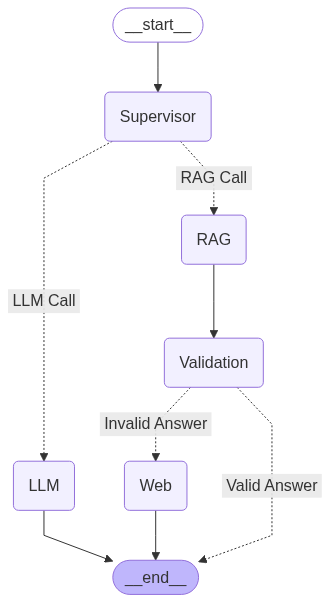

In [208]:
from langgraph.graph import StateGraph, END
workflow=StateGraph(AgentState)

# add nodes:
workflow.add_node("Supervisor", supervisor_fun)
workflow.add_node("LLM", llm_fun)
workflow.add_node("RAG", rag_fun)
workflow.add_node("Validation", validation_fun)
workflow.add_node("Web", web_fun)

# set entry
workflow.set_entry_point("Supervisor")

# add edges:
workflow.add_conditional_edges("Supervisor", sup_router,
                                                        {
                                                            "RAG Call": "RAG",
                                                            "LLM Call": "LLM",
                                                        })
workflow.add_edge("LLM", END)
workflow.add_edge("RAG", "Validation")
workflow.add_conditional_edges("Validation", val_router,
                                                        {
                                                            "Invalid Answer": "Web",
                                                            "Valid Answer": END,
                                                        })
workflow.add_edge("Web", END)                 
workflow.compile()

### Create APP:

In [209]:
app=workflow.compile()

In [210]:
# state={"messages": ["Hello"]}
# app.invoke(state)

In [216]:
state={"messages": ["What is the GDP of USA"]}
app.invoke(state)

***** Supervisor Node *****
Question:  What is the GDP of USA
Response: Topic='USA' Reasoning='The query explicitly asks for the GDP of the USA.'
***** RAG Node *****
Question:  What is the GDP of USA
***** Validation Node *****
Question:  What is the GDP of USA
Answer:  The U.S. nominal GDP is estimated to be around $28 trillion USD as of 2024.  This represents approximately 25% of the global economy.  It holds the #1 ranking worldwide by nominal GDP.
Validation: Validation='Valid' Reasoning='The answer provides a numerical estimate of the US GDP and context without requiring external resources.'


{'messages': ['What is the GDP of USA',
  'USA',
  'The U.S. nominal GDP is estimated to be around $28 trillion USD as of 2024.  This represents approximately 25% of the global economy.  It holds the #1 ranking worldwide by nominal GDP.',
  'Valid']}

In [212]:
# state={"messages": ["What is the growth of world's most powerful economy?"]}
# app.invoke(state)

In [213]:
# state={"messages": ["What is LLM?"]}
# app.invoke(state)

In [214]:
# state={"messages": ["What is GDP?"]}
# app.invoke(state)

In [215]:
state={"messages": ["What is the longest road in USA"]}
app.invoke(state)

***** Supervisor Node *****
Question:  What is the longest road in USA
Response: Topic='USA' Reasoning='The query explicitly asks about the longest road in the USA.'
***** RAG Node *****
Question:  What is the longest road in USA
***** Validation Node *****
Question:  What is the longest road in USA
Answer:  I don't know.  The provided text is about the US economy and doesn't contain information about roads.
Validation: Validation='Invalid' Reasoning='The answer does not provide the length of the longest road in the USA; instead, it indicates a lack of information.'


{'messages': ['What is the longest road in USA',
  'USA',
  "I don't know.  The provided text is about the US economy and doesn't contain information about roads.",
  'Invalid']}